In [150]:
from os import mkdir, getcwd, path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import nipy
from nibabel import save

from nipy.modalities.fmri.glm import FMRILinearModel
from nipy.modalities.fmri.design_matrix import make_dmtx, DesignMatrix
from nipy.modalities.fmri.experimental_paradigm import \
    load_paradigm_from_csv_file
from nipy.labs.viz import plot_map, cm

## LOAD DATA

In [144]:
single_subject = "/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_behavioral/part1/CP_behavdata_24_1_p.dat"
single_subject_brain = "/Users/phoenix/Desktop/imaging_studies/ConceptualPriming/data_imaging/cp024/positive1/swracp024_p1.nii"

column_list =['condition', 'respout', 'RT', 'primeword', 'PrimeOnsetTime',
              'StimulusOnsetTime', 'TrialOffset', 'IAPS_ID', 'maxcatind', 'mincatind',
              'maxcatmean', 'mincatmean', 'maxmincat_power', 'AmusMean', 'AmusSD', 'AweMean',
              'AweSD','ExciMean','ExciSD','ContMean','ContSD','CongWord','CongNeutral','IncongWord','IncongNeutral']
subject_behavioural=pd.read_csv(single_subject,names=column_list,sep=' ')
subject_behavioural = subject_behavioural.drop([0,1])

## Create Design Matrix CSV

In [145]:
subject_behavioural

,condition,respout,RT,primeword,PrimeOnsetTime,StimulusOnsetTime,TrialOffset,IAPS_ID,maxcatind,mincatind,...,AweMean,AweSD,ExciMean,ExciSD,ContMean,ContSD,CongWord,CongNeutral,IncongWord,IncongNeutral
2,3,4,2.176,------,6.011,6.228,11.254,8120.000000,1,2,...,2.220000,1.450000,3.500000,1.840000,3.380000,1.770000,amused,innate,awe,dip
3,2,2,2.492,awe,17.215,17.432,22.458,8460.000000,1,2,...,2.600000,1.700000,3.020000,1.650000,3.000000,1.680000,amused,innate,awe,dip
4,1,1,2.776,awe,28.419,28.636,33.679,1850.000000,2,1,...,4.930000,1.850000,3.700000,1.810000,3.850000,1.790000,awe,dip,amused,innate
5,1,1,1.676,amused,38.104,38.321,43.330,1999.000000,1,2,...,2.520000,1.620000,3.970000,1.630000,3.820000,1.770000,amused,innate,awe,dip
6,2,4,1.868,awe,46.319,46.536,51.578,2208.000000,1,2,...,3.070000,1.980000,4.220000,1.690000,3.830000,1.800000,amused,innate,awe,dip
7,3,4,1.799,------,56.020,56.237,61.263,2501.000000,1,2,...,2.780000,1.860000,3.370000,1.610000,3.850000,1.680000,amused,innate,awe,dip
8,2,2,1.778,amused,65.721,65.938,70.964,5626.000000,2,1,...,5.420000,1.740000,5.130000,1.640000,4.000000,1.730000,awe,dip,amused,innate
9,2,3,2.014,awe,76.925,77.142,82.185,1811.000000,1,2,...,3.250000,1.860000,4.220000,1.590000,3.750000,1.840000,amused,innate,awe,dip
10,1,3,2.724,amused,89.415,89.632,94.675,1340.000000,1,2,...,3.030000,1.780000,3.500000,1.680000,3.880000,1.670000,amused,innate,awe,dip
11,3,5,2.563,------,101.905,102.122,107.164,5250.000000,2,1,...,4.050000,1.940000,2.900000,1.840000,3.700000,1.890000,awe,dip,amused,innate


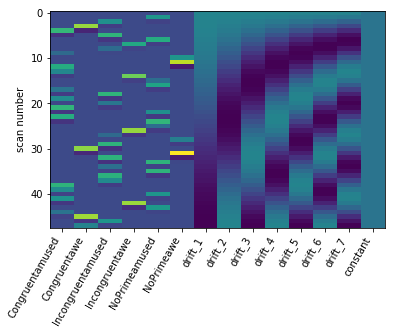

In [147]:


##NL TOOLS VERSION
data = {}
#data.columns = ["session_id", "condition_id", "onset","duration"]
def CreateStimColumn(conditions, emotion):
    stim_name = []
    for i in range(len(conditions)):
        
        stim_condition = ''
        condition = conditions[i]
        
        if(int(condition)==1):
            stim_condition += 'Congruent'
        elif(int(condition)==2):
            stim_condition += 'Incongruent'
        else:
            stim_condition += 'NoPrime'
        
        stim_condition += emotion[i]
        stim_name.append(stim_condition)
    return stim_name

data["Stim"] = CreateStimColumn(subject_behavioural.condition.values,
                               subject_behavioural.CongWord.values)
data["Onset"] = subject_behavioural.StimulusOnsetTime.values
data["Duration"] = np.ones(len(onset))*5
df = pd.DataFrame(data=data)
df = df.set_index('Onset')
df.to_csv('test_design_matrix_nipy.csv')

## NIPY VERSION
paradigm = nipy.modalities.fmri.experimental_paradigm.BlockParadigm(con_id=data['Stim'],
                                                                    onset=data['Onset'],
                                                                    duration=data['Duration'])

nipy_dm = make_dmtx(frame_times,paradigm)
nipy_dm.show()

## Create By TR nipy version

In [183]:
subject_behavioural['TR_Timing_Trial_Start']=subject_behavioural.StimulusOnsetTime.astype(float)/3
subject_behavioural['TR_Timing_Trial_Finish']=subject_behavioural.TrialOffset.astype(float)/3
#get all the full TRs 
subject_behavioural['rounded_tr_start'] = np.ceil(subject_behavioural['TR_Timing_Trial_Start'])
subject_behavioural['rounded_tr_finish'] = np.floor(subject_behavioural['TR_Timing_Trial_Finish'])
#now rounded_start - timing start assigns weight for index of rounded_tr_start-1
subject_behavioural['weight_for_preceding_tr'] = subject_behavioural['rounded_tr_start']-subject_behavioural['TR_Timing_Trial_Start']
subject_behavioural['weight_for_trailing_tr'] = subject_behavioural['TR_Timing_Trial_Finish']-subject_behavioural['rounded_tr_finish']

def CreateWeightedConditionMatrix(df, n_tr, condition):
    tr_space = np.zeros(n_tr)
    condition_specific = df.loc[df['condition'].astype(int)==condition]
    for index, row in condition_specific.iterrows():
        tr_space[int((row.rounded_tr_start-1)):int(row.rounded_tr_finish)-1]=1
        tr_space[int((row.rounded_tr_start-2))]=row.weight_for_preceding_tr
        tr_space[int(row.rounded_tr_finish)-1] = row.weight_for_trailing_tr
    return tr_space
    
stim = np.zeros((170,3))
stim[:,0]= CreateWeightedConditionMatrix(subject_behavioural,170,1)
stim[:,1]= CreateWeightedConditionMatrix(subject_behavioural,170,2)
stim[:,2]= CreateWeightedConditionMatrix(subject_behavioural,170,3)
stim
## ok ending here we need to figure out how to put these weights into the actual design paradigm


array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.924     ],
       [0.        , 0.        , 0.75133333],
       [0.        , 0.        , 0.        ],
       [0.        , 0.18933333, 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.486     , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.45466667, 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.22633333, 0.        , 0.        ],
       [0.22633333, 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.44333333, 0.        , 0.        ],
       [0.        , 0.488     , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.19266667, 0.        ],
       [0.        , 0.        , 0.25433333],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.421     ],
       [0.        , 0.02066667, 0.        ],
       [0.        , 1.        , 0.        ],
       [0.

In [185]:
subject_behavioural.loc[subject_behavioural['condition'].astype(int)==3][['TR_Timing_Trial_Start',
                                                                          'rounded_tr_start',
                                                                          'TR_Timing_Trial_Finish',
                                                                          'rounded_tr_finish']]

,TR_Timing_Trial_Start,rounded_tr_start,TR_Timing_Trial_Finish,rounded_tr_finish
2,2.076000,3.0,3.751333,3.0
7,18.745667,19.0,20.421000,20.0
11,34.040667,35.0,35.721333,35.0
12,38.209333,39.0,39.879000,39.0
16,51.144333,52.0,52.825000,52.0
17,55.313000,56.0,56.999667,56.0
23,75.578333,76.0,77.259000,77.0
25,82.045667,83.0,83.721000,83.0
26,85.274000,86.0,86.949333,86.0
29,96.344333,97.0,98.019667,98.0


In [138]:
contrasts = {}
n_columns = len(design_matrix.names)

contrasts['audio'] = np.array([1,0,0,0,0,0,0,0,0,0,0])

########################################
# Perform a GLM analysis
########################################

print('Fitting a GLM (this takes time)...')
fmri_glm = FMRILinearModel(single_subject_brain, nipy_dm.matrix,
                           mask='compute')
fmri_glm.fit(do_scaling=True, model='ar1')

Fitting a GLM (this takes time)...


ValueError: Response and predictors are inconsistent

In [142]:
FMRILinearModel??

/Users/phoenix/anaconda3/lib/python3.6/site-packages/nipy/modalities/fmri/design_matrix.py:311: RuntimeWarning: invalid value encountered in true_divide
  x = x / np.sqrt(np.sum(x ** 2, 0))


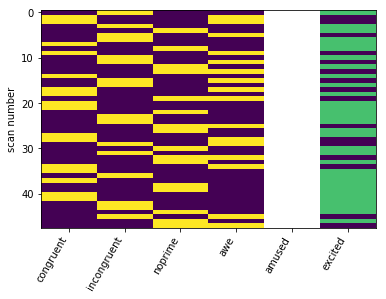

In [128]:
#6 names
congruent = (subject_behavioural.condition.astype(int).values == 1)*1
incongruent = (subject_behavioural.condition.astype(int).values == 2) * 1
noprime = (subject_behavioural.condition.astype(int).values == 3) * 1
awe = (subject_behavioural.CongWord == 'awe') * 1
amused = (subject_behavioural.CongWord == 'amused') * 1
excited = (subject_behavioural.CongWord == 'excited') * 1
matrix = np.column_stack((congruent,incongruent,noprime,awe,amused,excited))

names = ['congruent','incongruent','noprime','awe','amused','excited']

dm = DesignMatrix(matrix,names,frametimes=frame_times)
dm.show()

In [117]:
(subject_behavioural.condition.astype(int).values == 2)*1

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0])

In [118]:
(subject_behavioural.condition.astype(int).values == 3)*1

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1])

In [121]:
np.column_stack(((subject_behavioural.condition.astype(int).values == 1)*1,
                 (subject_behavioural.condition.astype(int).values == 2)*1,
                 (subject_behavioural.condition.astype(int).values == 3)*1))

array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1]])

In [122]:
matrix

array([[0, 1, 1, 0, 0, 1],
       [1, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 1, 1, 1, 0, 0],
       [0, 1, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [1, 0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0, 1],
       [0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 1, 0, 0, 1],
       [0, 1, 1, 1, 0, 0],
       [0, 1, 0, 0, 0, 1],
       [1, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 1, 1, 0, 0, 1],
       [0, 1, 1, 0, 0, 1],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 1],
       [1, 0, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 1],
       [0, 1, 0, 0, 0, 1],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [1, 0, 1, 1, 0, 0],
       [1, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 1],
 